# Minería de Datos (Master en Data Science, UIMP-UC)

## S11. Intercomparación de técnicas para clasificación

### Rodrigo Manzanas   
#### 9 Diciembre 2021

## Introducción

En esta práctica haremos una intercomparación de varias de las técnicas vistas hasta ahora para problemas de clasificación: árboles, modelos lineales generalizados (GLMs) y k-NN. Por tanto, pretende ser un repaso general cuyo objetivo es ayudaros a afianzar el manejo de estas técnicas (y los correspondientes aquetes de `R`) para un caso de estudio concreto: la predicción del evento binario ocurrencia de precipitación (lluvia sí/lluvia no).

Comenzaremos cargando el dataset `meteo`, que ya ha sido utilizado en sesiones anteriores. Como sabéis, la variable objetivo en este dataset es la precipitation diaria en Lisboa durante el período 1979-2008, y para predecirla se dispone de 320 predictores que describen la circulación atmosférica de larga escala. Dichos predictores corresponden a un conjunto de 8 variables meteorológicas
* altura geopotencial en 500 hPa
* temperatura en superficie, en 850 hPa, 700 hPa y 500 hPa
* humedad específica en 850 hPa y 500 hPa
* presión a nivel del mar

definidas sobre un dominio geográfico que incluye 40 puntos sobre la península Ibérica.

In [1]:
## loading data
data = read.csv("/home/jovyan/04-DataMining/Data/meteo.csv")
y = data[, 2]  # predictand
x = data[, -c(1,2)]  # predictors
length(y)
dim(x)
rm(data)

[1] 10958

[1] 10958   320

Para agilizar los tiempos de cómputo, reduciremos la dimensionalidad de nuetro problema. Una alternativa para tal fin es el uso de componentes principales (PCs, en inglés). Sin embargo, para no limitar la interpretabilidad de los resultados obtenidos con árboles, utilizaremos otra aproximación aquí. En concreto, optaremos por un análisis de correlaciones, en el que se calcula la correlación de Spearman entre nuestra variable objetivo y todas las variables predictoras disponibles. La idea es que, cuanto más fuerte sea esta correlación, mayor es el vínculo físico entre predictando y predictor, y por tanto, más útil es la información que nos aporta ese predictor. Este análisis nos permite descartar predictores poco relevantes.
Siguiendo esta idea, calcularemos la correlación existente entre nuestro predictando y los 320 predictores, y eliminaremos aquellos con correlaciones entre -0.4 y 0.4. ¿Cuánto se ha reducido la dimensionalidad del problema?

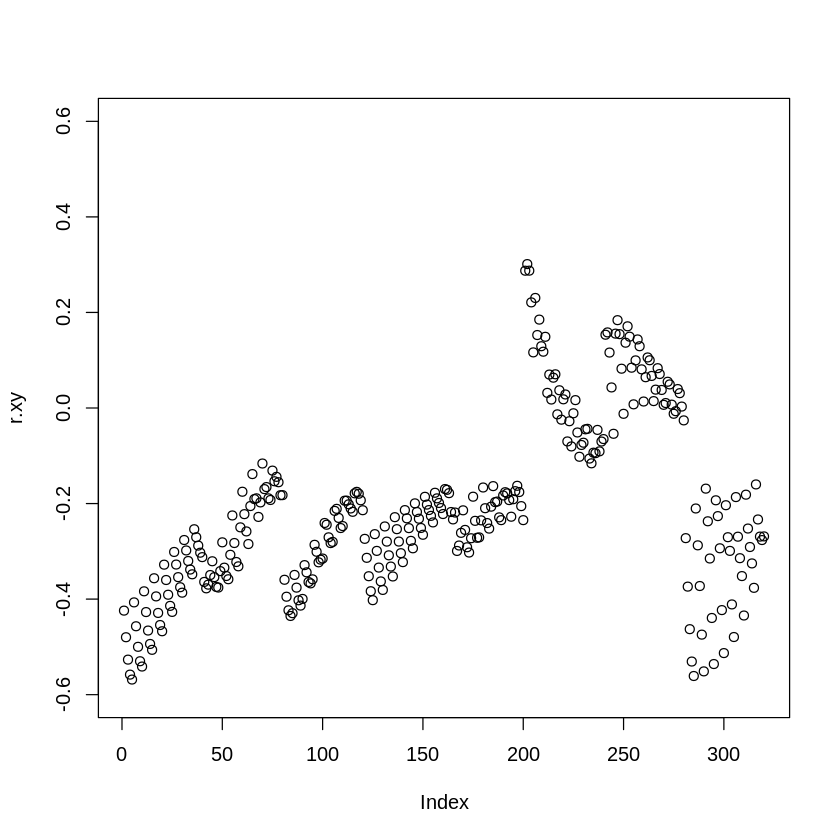

In [2]:
## informed selection of predictors, based on a correlation analysis
r.xy = c()
for (ivar in 1:ncol(x)) {
  r.xy[ivar] = cor(y, x[, ivar], method = "spearman")
}
plot(r.xy, ylim = c(-0.6, 0.6))

ind.sele = which(abs(r.xy) > 0.4)


In [3]:
length(ind.sele)

[1] 37

Para simplificar aún más los cálculos, nos limitaremos a los primeros 5000 días del dataset. Como hemos hecho otras veces, consideraremos una partición de la muestra en dos subconjuntos independientes, train y test, escogidos aleatoriamente (75% para entrenar y 25% para testear).

In [4]:
# keeping only 5000 days for this example
n = 5000
y = y[1:n]
x = x[1:n, ind.sele]

# train/test partition
set.seed(0)
indtrain = sample(1:n, round(0.75*n))  
indtest = setdiff(1:n, indtrain)

## Árboles de clasificación

En primer lugar, tenemos que crear la variable binaria ocurrencia de precipitación (considera un umbral de 1mm). A partir de esta nueva variable (*occ*), de tipo factor, construiremos el dataframe asociado al problema.

In [5]:
# binary occurrence
occ = y
occ[which(y < 1)] = 0  # dry day
occ[which(y >= 1)] = 1  # rainy day

# dataframe for occurrence
df.occ = data.frame(y.occ = as.factor(occ), predictors = x)

A continuación construiremos el árbol completo (usa la función *tree*). ¿Cuántos nodos terminales (hojas) obtienes? ¿Qué variables predictoras dan lugar a las primeras divisiones del árbol?


Classification tree:
tree(formula = y.occ ~ ., data = df.occ, subset = indtrain, mincut = 1, 
    minsize = 2, mindev = 0)
Variables actually used in tree construction:
 [1] "predictors.X285" "predictors.X284" "predictors.X25"  "predictors.X1"  
 [5] "predictors.X83"  "predictors.X84"  "predictors.X5"   "predictors.X304"
 [9] "predictors.X300" "predictors.X20"  "predictors.X10"  "predictors.X8"  
[13] "predictors.X283" "predictors.X89"  "predictors.X13"  "predictors.X14" 
[17] "predictors.X15"  "predictors.X88"  "predictors.X290" "predictors.X24" 
[21] "predictors.X299" "predictors.X3"   "predictors.X18"  "predictors.X305"
[25] "predictors.X2"   "predictors.X4"   "predictors.X289" "predictors.X310"
[29] "predictors.X294" "predictors.X295" "predictors.X85"  "predictors.X6"  
[33] "predictors.X9"   "predictors.X19"  "predictors.X125" "predictors.X12" 
Number of terminal nodes:  292 
Residual mean deviance:  0 = 0 / 3458 
Misclassification error rate: 0 = 0 / 3750 

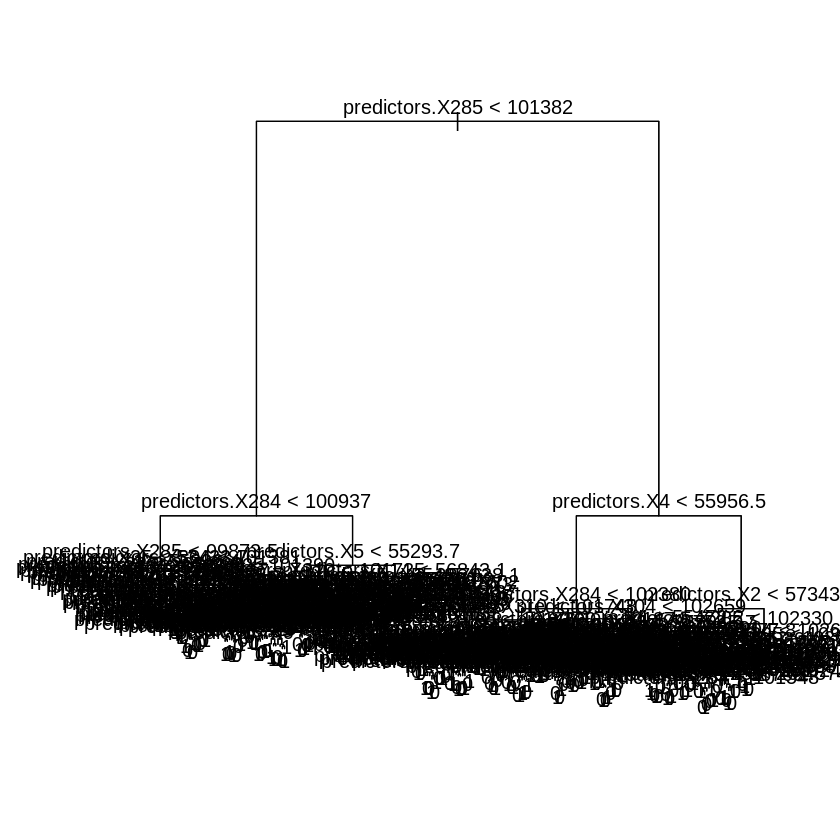

In [8]:
## complete tree (based on training dataset)
library(tree)
t.occ = tree(y.occ ~., df.occ, subset = indtrain,
            mincut = 1,
            minsize = 2,
            mindev = 0)
plot(t.occ); text(t.occ, pretty = F)
summary(t.occ)

Para simplificar este árbol tan complejo tendremos que podarlo adecuadamente (*prune.tree*). Utiliza una cross-validación con un 10-fold (*cv.tree*) para encontrar el número de hojas del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

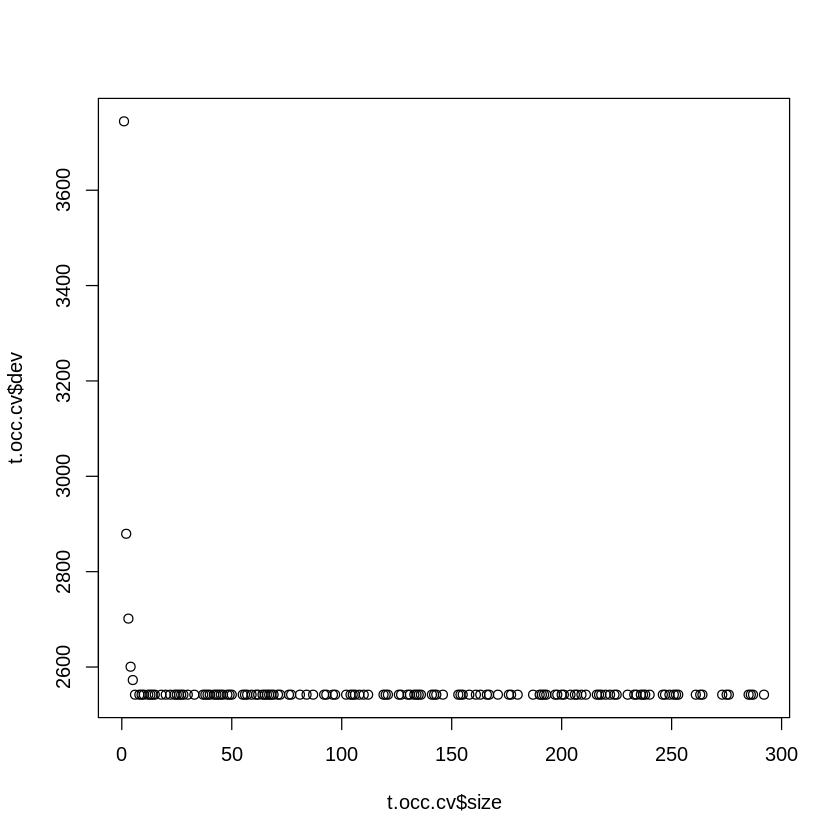

In [12]:
## 10-fold cross-validation for determining optimum number of leaves
t.occ.cv = cv.tree(t.occ, K = 10)
plot(t.occ.cv$size, t.occ.cv$dev)  # deviance as a function of number of leaves

ERROR: Error in xy.coords(x, y, recycle = TRUE, setLab = FALSE): 'x' is a list, but does not have components 'x' and 'y'


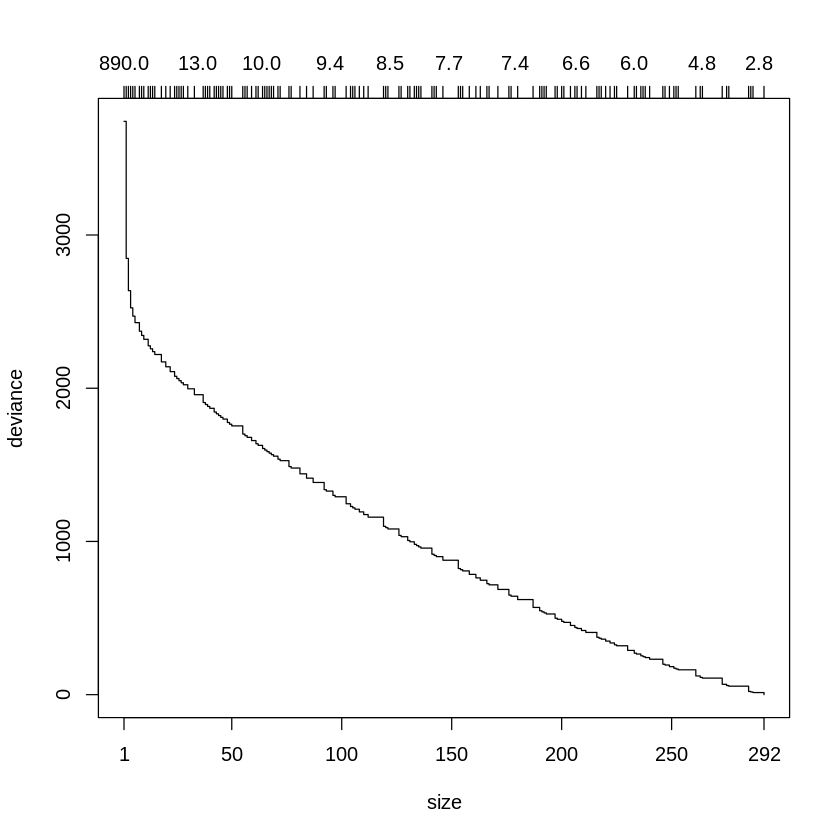

In [14]:
## pruning
t.occ.opt = prune.tree(t.occ)
plot(t.occ.opt); text(t.occ.opt)
summary(t.occ.opt)

A la vista de la representación gráfica del árbol, ya sabes cuál será la profundidad (número de niveles verticales) óptima. Utiliza el paquete *rpart* para entrenar un árbol con esa profundidad, represéntalo (*rpart.plot*) y comprueba si hay diferencias.

In [15]:
library(rpart)
t.occ.opt2 = rpart(y.occ~., df.occ, subset = indtrain, maxdepth = 3)

library(rpart.plot)
rpart.plot(***)

ERROR: Error in parse(text = x, srcfile = src): <text>:5:12: unexpected '^'
4: library(rpart.plot)
5: rpart.plot(**
              ^


Utiliza los dos árboles para predecir en el test.

In [16]:
## occurrence prediction for test
# tree fitted with 'tree'
pred.t.occ = predict(t.occ.opt, df.occ[indtest,], type = "class")
str(pred.t.occ)

# tree fitted with 'rpart'
pred.t.occ2 = predict(t.occ.opt, df.occ[indtest,], type = "class")
str(pred.t.occ2)

ERROR: Error in UseMethod("predict"): no applicable method for 'predict' applied to an object of class "c('prune', 'tree.sequence')"


Valida tus predicciones en función del accuracy (tasa de ciertos) y la correlación de Spearman. Esta última nos dará una idea de lo bien/mal que la predicción reproduce la estructura temporal de la serie observada.

In [ ]:
## validation
# accuracy 
acc.t = ***
acc.t2 = ***
c(acc.t, acc.t2)

# correlation
cor.t = ***
cor.t2 = ***
c(cor.t, cor.t2)

Como último ejercicio con árboles, utiliza esta vez *caret* para determinar la profundidad óptima del árbol. Para ello, barre profundidades de 1 a 20 considerando cross-validación 10-fold que repetirás 20 veces. A continuación, construye un árbol que tenga esa profundidad que has encontrado como óptima (*rpart*) y utilízalo para predecir en el test. Valida las predicciones que obtengas en función del accuracy y la correlación y compara los resultados con los que habías obtenido anteriormente.

In [ ]:
library(caret)
## finding optimum depth
trctrl = trainControl(***)
t.opt = train(***
                method = "rpart2",
                trControl = trctrl,                
                ***)
plot(t.opt)

In [ ]:
## building tree up
t.occ.opt3 = rpart(***)
rpart.plot(t.occ.opt3, extra = 1)

In [ ]:
## occurrence prediction for test
# tree fitted with 'rpart' (based on optimum configuration returned by caret)
pred.t.occ3 = predict(***, type = "class")

## validation
# accuracy 
acc.t3 = ***

# correlation
cor.t3 = ***
c(acc.t3, cor.t3)

## Modelos lineales generalizados (GLMs)

Usaremos a continuación GLMs para el mismo problema. Dado que nuestra variable objetivo es binaria, utilizaremos la familia *binomial* con función de enlace *logit* (regresión logística) dentro de la función *glm* del paquete *stats*.

In [ ]:
## GLM for occurrence
glm.occ = glm(y.occ ~ ., df.occ, subset = indtrain, family = ***)

Una vez tenemos el modelo, lo utilizamos para predecir en el test. Tendremos que convertir la predicción probabilística obtenida en binaria (considera para ello un umbral 0.5).

In [ ]:
## occurrence prediction for test
pred.glm.occ = predict(***, type = ***)
str(pred.glm.occ)
hist(pred.glm.occ, 100)
pred.glm.occ = ifelse(***)
str(pred.glm.occ)

In [ ]:
## validation
# accuracy
acc.glm = ***
acc.glm

# correlation
cor.glm = ***
cor.glm

A continuación, entrena otros dos GLMs, uno que considere como único predictor una de las variables con mayor poder explicativo y otro que utilice como único predictor cualquier otra variable. Básate en los árboles para hacer estas elecciones. Utiliza ambos GLMs para predecir en el test y valida tus predicciones en función del accuracy y la correlación. ¿Qué conclusiones obtienes?

In [ ]:
# GLM for occurrence (one good predictor)
glm.occ2 = glm(y.occ ~ ***,
              df.occ, subset = indtrain, family = ***)
pred.glm.occ2 = predict(***, type = ***)
pred.glm.occ2 = ifelse(***)
acc.glm2 = ***
cor.glm2 = ***
c(acc.glm2, cor.glm2)

# GLM for occurrence (one random predictor)
glm.occ3 = glm(y.occ ~ ***,
              df.occ, subset = indtrain, family = ***)
pred.glm.occ3 = predict(***, type = ***)
pred.glm.occ3 = ifelse(***)
acc.glm3 = ***
cor.glm3 = ***
c(acc.glm3, cor.glm3)

## k nearest neighbors (k-NN)

La última de las técnicas a utilizar será la k-NN. Comenzaremos por una versión de k-NN en la que sólo se considere el vecino más cercano (utiliza la función *knn* del paquete *class*). 

**Nota:** Recuerda que en la técnica k-NN es muy importante pre-procesar adecuadamente (estandarizar) los predictores.

In [ ]:
## prediction for test (with k = 1)
library(class)
pred.knn1 = knn(train = scale(***), 
                   test = scale(***), 
                   cl = ***,
                   k = 1)
str(pred.knn1)

El único parámetro a ajustar en la técnica k-NN es k (número de vecinos). Utilizaremos el paquete *caret* para encontrar el k óptimo en nuestro problema. Para ello, considera una cross-validación con 10 folds sobre el dataset de train barriendo todos los k impares desde 1 a 50.

In [ ]:
library(caret)
## finding optimum k
trctrl = trainControl(***)
knn.opt = train(***
                method = "knn",
                trControl = trctrl,
                preProcess = ***,
                ***)
plot(knn.opt)

Utiliza este *k* óptimo para predecir en el test.

In [ ]:
# prediction for test (with optimum k)
pred.knn.opt = knn(train = scale(***), 
                   test = scale(***), 
                   cl = ***,
                   k = ***)
str(pred.knn.opt)

Calcula el accuracy y la correlación que se obtiene con las dos predicciones (con *k=1* y con *k=óptimo*).

In [ ]:
## validation
# accuracy
acc.knn1 = ***
acc.knn.opt = ***
print(c(acc.knn1, acc.knn.opt))

# correlation
cor.knn1 = ***
cor.knn.opt = ***
print(c(cor.knn1, cor.knn.opt))